In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data_path = '/content/Continuous_DateS_Range-LAPTOP-98PL5KBA.csv'
df = pd.read_csv(data_path)
print("succes")

succes


In [3]:
relevant_columns = [
    'crawl_timestamp',
    'variant_price',
    'variant_compare_at_price',
    'actual_color',
    'dominant_color',
    'product_type',
    'ideal_for',
    'is_in_stock'
]

df_selected = df[relevant_columns]

# Displaying the selected dataframe
print(df_selected.head())

  crawl_timestamp  variant_price  variant_compare_at_price  \
0      2019-01-01           2396                      5990   
1      2019-01-01            698                      1995   
2      2019-01-01            719                      1799   
3      2019-01-01            799                      1599   
4      2019-01-01           2024                      4499   

               actual_color dominant_color  \
0             Black | Cream          Black   
1                      Blue           Blue   
2  Yellow | Brown | Mustard        Mustard   
3             Blue | Purple           Blue   
4                     Black          Black   

                                product_type ideal_for   is_in_stock  
0  Kurta with Pyjamas & Printed Nehru Jacket       Men      In Stock  
1                             Straight Kurta       Men  Out of Stock  
2                               A-Line Kurta     Women  Out of Stock  
3                                        NaN    Unisex      In Sto

In [4]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = [], []
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Example usage:
window_size = 29  # Example window size
future_span = 30  # Example future span

# Assuming df_selected is the dataframe with selected relevant columns
series = series_to_supervised(df_selected, window=window_size, lag=future_span)
print(series.head())

     crawl_timestamp(t-29)  variant_price(t-29)  \
1794            2019-09-15               1249.0   
1795            2019-09-15                359.0   
1796            2019-09-16                899.0   
1797            2019-09-16               1119.0   
1799            2019-09-16                749.0   

      variant_compare_at_price(t-29) actual_color(t-29) dominant_color(t-29)  \
1794                          2499.0             Maroon               Maroon   
1795                          1199.0              Brown                Brown   
1796                          1799.0       Teal | Green                 Teal   
1797                          1599.0                Red                  Red   
1799                          1499.0               Blue                 Blue   

     product_type(t-29) ideal_for(t-29) is_in_stock(t-29)  \
1794         Maxi Dress           Women      Out of Stock   
1795     Flared Palazzo           Women          In Stock   
1796     Straight Kurta      

In [6]:
import pandas as pd

# Load your dataset
data_path = '/content/Continuous_DateS_Range-LAPTOP-98PL5KBA.csv'
df = pd.read_csv(data_path)

# Display the first few rows to understand the structure
print(df.head())

# Example of processing without 'store_id'
# Group by relevant columns and perform aggregation (e.g., mean of variant_price by product_id)
df_items_sales = df.groupby(['product_id', 'crawl_timestamp'], as_index=False).agg({
    'variant_price': 'mean'
})

# Optionally, sort the data by crawl_timestamp or any other relevant column
df_items_sales = df_items_sales.sort_values('crawl_timestamp')

# Display the processed dataframe
print(df_items_sales.head())

                            uniq_id crawl_timestamp  product_id  \
0  b511a3268e0fd7aa10a6d7728202aff1      2019-01-01     5965158   
1  e0ea9e59f65f2cb82c1dd43c0d087b71      2019-01-01     2439641   
2  e5d919fab7a0d4e976d442b5a24547aa      2019-01-01     2370037   
3  cb1508097ed71472128cddbe569d6e22      2019-01-01     8456497   
4  4cc45701da275bf75beeaae79e83e59d      2019-01-01     4679834   

                                                link          size  \
0  https://www.myntra.com/kurta-sets/deyann/deyan...             M   
1  https://www.myntra.com/kurtas/british-club/bri...            XL   
2  https://www.myntra.com/kurtas/anouk/anouk-wome...            XS   
3  https://www.myntra.com/bedsheets/welhome/welho...  Double Queen   
4  https://www.myntra.com/kurta-sets/sojanya/soja...           XXL   

            variant_sku         brand  \
0             5965158_M        DEYANN   
1            2439641_XL  British Club   
2            2370037_XS         Anouk   
3  8456497_D

In [7]:
# Parameters for sequence generation
window = 29
future_span = 30

# Create sequences using the processed data
series = series_to_supervised(df_items_sales.drop('crawl_timestamp', axis=1), window=window, lag=future_span)

# Display the first few rows of the generated sequence data
print(series.head())

       product_id(t-29)  variant_price(t-29)  product_id(t-28)  \
13929         7263480.0               2239.0         4679834.0   
3802          4679834.0               2024.0         8456497.0   
11238         8456497.0                799.0         2370037.0   
4389          2370037.0                719.0         2439641.0   
618           2439641.0                698.0         9005383.0   

       variant_price(t-28)  product_id(t-27)  variant_price(t-27)  \
13929               2024.0         8456497.0                799.0   
3802                 799.0         2370037.0                719.0   
11238                719.0         2439641.0                698.0   
4389                 698.0         9005383.0               3374.0   
618                 3374.0         5965158.0               2396.0   

       product_id(t-26)  variant_price(t-26)  product_id(t-25)  \
13929         2370037.0                719.0         2439641.0   
3802          2439641.0                698.0         900

In [8]:
# Define the window size
window = 29

# Identify the last item and store columns based on the window size
last_product = 'product_id(t-%d)' % window
last_variant_price = 'variant_price(t-%d)' % window
current_product = 'product_id(t)'
current_variant_price = 'variant_price(t)'

# Filter the series to remove edge cases where not enough values to complete a series
series = series[(series[current_product] == series[last_product])]
series = series[(series[current_variant_price] == series[last_variant_price])]

# Since you mentioned predicting using the 'variant_price' column, ensure it's included
# You might need to adjust this part based on your specific modeling needs
# Assuming 'variant_price(t+30)' is the target column for prediction
series_to_predict = series[['product_id(t)', 'variant_price(t)', 'product_id(t+30)', 'variant_price(t+30)']]

# Display the filtered series
print(series_to_predict.head())

       product_id(t)  variant_price(t)  product_id(t+30)  variant_price(t+30)
4854         3250330             749.0         8791459.0                849.0
11378        8349325             679.0         9934875.0               1104.0
487          1464015            2690.0         7424730.0               1274.0


In [9]:
# Define the column names based on your dataset structure
last_product = 'product_id(t-%d)' % window
current_product = 'product_id(t)'

last_variant_price = 'variant_price(t-%d)' % window
current_variant_price = 'variant_price(t)'

# Filter out sequences that do not have enough data points
series_filtered = series[
    (series[current_product].notnull()) &  # Ensure current product id is not null
    (series[current_variant_price].notnull()) &  # Ensure current variant price is not null
    (series[last_product].notnull()) &  # Ensure last product id in window is not null
    (series[last_variant_price].notnull()) &  # Ensure last variant price in window is not null
    (series['product_id(t+30)'].notnull())  # Ensure there's a value for product id 30 steps ahead
]

# Display the filtered series or use it for further processing
print(series_filtered.head())

       product_id(t-29)  variant_price(t-29)  product_id(t-28)  \
4854          3250330.0                749.0         8056613.0   
11378         8349325.0                679.0         8965245.0   
487           1464015.0               2690.0         1536736.0   

       variant_price(t-28)  product_id(t-27)  variant_price(t-27)  \
4854                1624.0         3890441.0               1959.0   
11378               1890.0         9430329.0                990.0   
487                  599.0         1585055.0                524.0   

       product_id(t-26)  variant_price(t-26)  product_id(t-25)  \
4854          8113883.0               1049.0         8791333.0   
11378         2064394.0               2239.0         6971964.0   
487           7419469.0               1599.0         2241424.0   

       variant_price(t-25)  ...  product_id(t-3)  variant_price(t-3)  \
4854                 799.0  ...        8627491.0              1349.0   
11378               8478.0  ...        9366067.0 

In [10]:
# Assuming you have already created or loaded your series dataframe
# Define your window size and future span
window = 29
future_span = 30

# Define the column names based on your dataset structure
last_variant_price = 'variant_price(t-%d)' % window
current_variant_price = 'variant_price(t)'

# Print out the columns in series to verify their names
print("Columns in series DataFrame:")
print(series.columns)

# Remove all but the variant_price (or sales) column
columns_to_drop = [('%s(t+%d)' % (col, future_span)) for col in ['product_id', 'variant_price']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['product_id', 'variant_price']]

# Drop the columns if they exist in the dataframe
series = series.drop(columns=[col for col in columns_to_drop if col in series.columns], errors='ignore')

# Display the modified series or use it for further processing
print("\nModified DataFrame:")
print(series.head())

Columns in series DataFrame:
Index(['product_id(t-29)', 'variant_price(t-29)', 'product_id(t-28)',
       'variant_price(t-28)', 'product_id(t-27)', 'variant_price(t-27)',
       'product_id(t-26)', 'variant_price(t-26)', 'product_id(t-25)',
       'variant_price(t-25)', 'product_id(t-24)', 'variant_price(t-24)',
       'product_id(t-23)', 'variant_price(t-23)', 'product_id(t-22)',
       'variant_price(t-22)', 'product_id(t-21)', 'variant_price(t-21)',
       'product_id(t-20)', 'variant_price(t-20)', 'product_id(t-19)',
       'variant_price(t-19)', 'product_id(t-18)', 'variant_price(t-18)',
       'product_id(t-17)', 'variant_price(t-17)', 'product_id(t-16)',
       'variant_price(t-16)', 'product_id(t-15)', 'variant_price(t-15)',
       'product_id(t-14)', 'variant_price(t-14)', 'product_id(t-13)',
       'variant_price(t-13)', 'product_id(t-12)', 'variant_price(t-12)',
       'product_id(t-11)', 'variant_price(t-11)', 'product_id(t-10)',
       'variant_price(t-10)', 'product_id(t

In [11]:
# Load your dataset
data_path = '/content/Continuous_DateS_Range-LAPTOP-98PL5KBA.csv'
df = pd.read_csv(data_path)

# Define the window size and future span
window = 29
future_span = 30

# Create lagged features for variant_price
for i in range(1, window + 1):
    df[f'variant_price(t-{i})'] = df['variant_price'].shift(i)

# Create the future prediction column variant_price(t+30)
df[f'variant_price(t+{future_span})'] = df['variant_price'].shift(-future_span)

# Now, verify if variant_price(t+30) is in the DataFrame columns
print('variant_price(t+30)' in df.columns)

True


In [12]:
from sklearn.model_selection import train_test_split

# Define the label column
labels_col = f'variant_price(t+{future_span})'

# Extract labels (future prices)
labels = df[labels_col]

# Drop the label column from predictors (X sequences)
X = df.drop(labels_col, axis=1)

# Split the data into training and validation sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X, labels, test_size=0.4, random_state=0)

# Display the shapes of the datasets
print('Train set shape:', X_train.shape)
print('Validation set shape:', X_valid.shape)

# Display the first few rows of X_train for verification
print('\nFirst few rows of X_train:')
print(X_train.head())

Train set shape: (9000, 55)
Validation set shape: (6000, 55)

First few rows of X_train:
                                uniq_id crawl_timestamp  product_id  \
4434   04ac75e6b8e651b0321c68fe38b285b6      2020-10-09     8178285   
738    968bf8689a12587ce23c1dec60fc02c5      2019-04-18     9479303   
10827  00d9f8e29e2bc84f69a02e424c9037b0      2023-05-01     6914116   
13200  07ed01165e6ed6b72a1ae7ace078eb38      2024-04-12     5125465   
13639  22cd7d6b965d8950e2e89243de04f298      2024-06-15      326955   

                                                    link size variant_sku  \
4434   https://www.myntra.com/kurta-sets/rajubhai-har...   XL  8178285_XL   
738    https://www.myntra.com/kurtas/libas/libas-wome...    L   9479303_L   
10827                     https://www.myntra.com/6914116    S   6914116_S   
13200                     https://www.myntra.com/5125465   XL  5125465_XL   
13639                      https://www.myntra.com/326955   XL   326955_XL   

                     

In [13]:
# Assuming X_train and X_valid are your prepared predictor DataFrames

# Reshape X_train and X_valid into 3D arrays
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

# Print the shapes of the reshaped arrays
print('Train set shape:', X_train_series.shape)
print('Validation set shape:', X_valid_series.shape)

Train set shape: (9000, 55, 1)
Validation set shape: (6000, 55, 1)


In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from keras.optimizers import Adam

# Parameters
epochs = 500
batch_size = 256
learning_rate = 0.0003
adam = Adam(learning_rate)

# Construct the neural network model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))

# Compile the model
model_cnn.compile(loss='mse', optimizer=adam)

# Display the model summary
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        76,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,477 (302.64 KB)

 Trainable params: 77,477 (302.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Define hyperparameters
epochs = 500
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(learning_rate=lr)

# Select only numeric columns
numeric_columns = ['variant_price']
window = 29
future_span = 30
for i in range(1, window + 1):
    numeric_columns.append(f'variant_price(t-{i})')
numeric_columns.append(f'variant_price(t+{future_span})')

# Filter the dataframe to keep only numeric columns
df_numeric = df[numeric_columns]

# Drop rows with NaN values that may have been introduced by shifting
df_numeric = df_numeric.dropna()

# Extract labels
labels_col = f'variant_price(t+{future_span})'
labels = df_numeric[labels_col]
X = df_numeric.drop(labels_col, axis=1)

# Split the data into training and validation sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X, labels.values, test_size=0.4, random_state=0)

# Convert data to float32
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
Y_train = Y_train.astype(np.float32)
Y_valid = Y_valid.astype(np.float32)

# Reshape the data
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

# Display the shapes of the datasets
print('Train set shape:', X_train_series.shape)
print('Validation set shape:', X_valid_series.shape)

# Construct the neural network
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

# Define early stopping monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50,
                        verbose=1, mode='auto', restore_best_weights=True)

# Fit the model
cnn_history = model_cnn.fit(
    X_train_series, Y_train,
    validation_data=(X_valid_series, Y_valid),
    epochs=epochs,
    batch_size=batch,
    callbacks=[monitor],
    verbose=2
)

# Print the training history
print(cnn_history.history)

Train set shape: (8964, 30, 1)
Validation set shape: (5977, 30, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 23, 64)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        35,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,877 (140.14 KB)

 Trainable params: 35,877 (140.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
36/36 - 3s - 78ms/step - loss: 1683760.8750 - val_loss: 1352190.2500
Epoch 2/500
36/36 - 1s - 29ms/step - loss: 1486288.2500 - val_loss: 1305183.0000
Epoch 3/500
36/36 - 1s - 27ms/step - loss: 1461322.8750 - val_loss: 1290192.6250
Epoch 4/500
36/36 - 1s - 30ms/step - loss: 1440147.1250 - val_loss: 1295312.6250
Epoch 5/500
36/36 - 1s - 16ms/step - loss: 1443989.2500 - val_loss: 1281119.1250
Epoch 6/500
36/36 - 1s - 16ms/step - loss: 1427998.6250 - val_loss: 1283618.1250
Epoch 7/500
36/36 - 1s - 18ms/step - loss: 1423605.0000 - val_loss: 1275761.2500
Epoch 8/500
36/36 - 1s - 15ms/step - loss: 1416300.2500 - val_loss: 1280053.8750
Epoch 9/500
36/36 - 1s - 16ms/step - loss: 1417076.0000 - val_loss: 1276608.5000
Epoch 10/500
36/36 - 1s - 18ms/step - loss: 1419647.1250 - val_loss: 1275945.7500
Epoch 11/500
36/36 - 1s - 14ms/step - loss: 1413844.1250 - val_loss: 1274333.8750
Epoch 12/500
36/36 - 1s - 19ms/step - loss: 1409619.7500 - val_loss: 1276757.1250
Epoch 13/500
36/36 - 1s -

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the training and validation sets
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)

# Evaluate the predictions
train_rmse = np.sqrt(mean_squared_error(Y_train, cnn_train_pred))
valid_rmse = np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred))

# Print the RMSE values
print('Train RMSE:', train_rmse)
print('Validation RMSE:', valid_rmse)

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train RMSE: 1174.972712449102
Validation RMSE: 1128.8639754195365


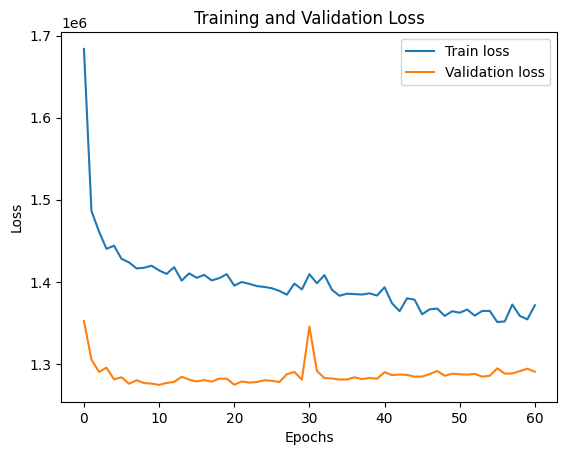

In [17]:
import matplotlib.pyplot as plt

# Replace cnn_history with your actual training history object
fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


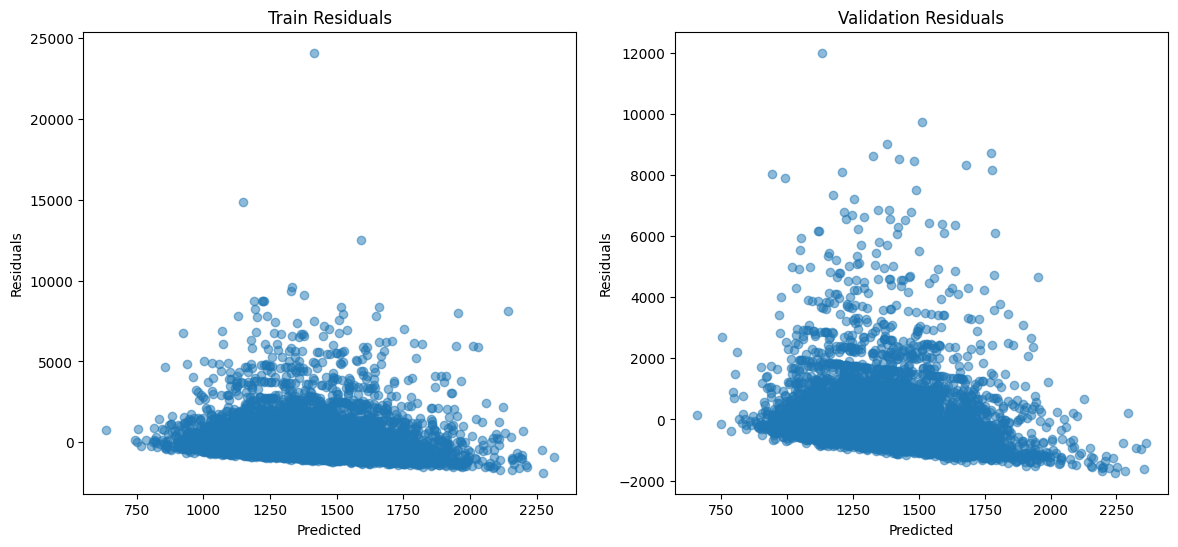

In [18]:
import matplotlib.pyplot as plt

# Calculate residuals
train_residuals = Y_train - cnn_train_pred.flatten()
valid_residuals = Y_valid - cnn_valid_pred.flatten()

# Plot residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(cnn_train_pred, train_residuals, alpha=0.5)
plt.title('Train Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(cnn_valid_pred, valid_residuals, alpha=0.5)
plt.title('Validation Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.show()

In [19]:
from sklearn.dummy import DummyRegressor

# Create a baseline model
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, Y_train)
dummy_pred = dummy_regressor.predict(X_valid)

# Calculate RMSE for baseline model
dummy_rmse = np.sqrt(mean_squared_error(Y_valid, dummy_pred))
print('Baseline model RMSE:', dummy_rmse)

Baseline model RMSE: 1108.2421892348261


In [21]:
# Step 3: Neurosymbolic Integration
# Implement rule extraction and logical reasoning methods here
def apply_rules(cnn_features, demographic_data):
    # Implement logical rules based on cnn_features and demographic_data
    # Example:
    if demographic_data['age'] < 30 and cnn_features['style'] == 'casual':
        return 'Preference for casual styles among younger age groups'
    else:
        return 'No specific preference inferred'
print("success")

success


In [22]:
# Example symbolic reasoning function based on actual data
def apply_rules(cnn_features, demographic_data):
    predictions = []
    for i in range(len(cnn_features)):
        cnn_feature = cnn_features[i]  # CNN features for current sample
        demographic_info = demographic_data.iloc[i]  # Demographic info for current sample

        # Example rule-based reasoning based on insights
        if demographic_info['age'] < 30 and cnn_feature[0] > 0.5:  # Example condition based on insights
            prediction = 'Preference for trendy and youthful fashion styles'
        elif demographic_info['gender'] == 'Female' and cnn_feature[1] > 0.3:  # Example condition based on insights
            prediction = 'Preference for elegant and feminine fashion styles'
        else:
            prediction = 'No specific preference inferred'

        predictions.append(prediction)

    return predictions
print("success")

success


In [24]:
import pandas as pd

# Load your dataset
file_path = '/content/Continuous_DateS_Range-LAPTOP-98PL5KBA.csv'
df = pd.read_csv(file_path)

# Display the columns to understand the structure of your dataset
print("Columns in the Dataset:")
print(df.columns)

Columns in the Dataset:
Index(['uniq_id', 'crawl_timestamp', 'product_id', 'link', 'size',
       'variant_sku', 'brand', 'care_instructions', 'dominant_material',
       'title', 'actual_color', 'dominant_color', 'product_type', 'images',
       'body', 'product_details', 'size_fit', 'complete_the_look', 'type',
       'variant_price', 'variant_compare_at_price', 'ideal_for', 'is_in_stock',
       'inventory', 'specifications', 'Unnamed: 25'],
      dtype='object')


In [25]:
import pandas as pd

# Load your dataset
file_path = '/content/Continuous_DateS_Range-LAPTOP-98PL5KBA.csv'
df = pd.read_csv(file_path)

# Display the columns to understand the structure of your dataset
print("Columns in the Dataset:")
print(df.columns)

# Replace ellipses with actual column names from your dataset
cnn_feature_columns = ['variant_price', 'variant_compare_at_price']  # Example CNN feature columns
demographic_columns = ['actual_color', 'dominant_color', 'product_type']  # Example demographic columns

# Extract CNN features and demographic data
X_cnn_features_actual = df[cnn_feature_columns].values
demographic_data_actual = df[demographic_columns].values

# Display the first few rows to verify the data loading
print("\nCNN Features:")
print(X_cnn_features_actual[:5])

print("\nDemographic Data:")
print(demographic_data_actual[:5])

Columns in the Dataset:
Index(['uniq_id', 'crawl_timestamp', 'product_id', 'link', 'size',
       'variant_sku', 'brand', 'care_instructions', 'dominant_material',
       'title', 'actual_color', 'dominant_color', 'product_type', 'images',
       'body', 'product_details', 'size_fit', 'complete_the_look', 'type',
       'variant_price', 'variant_compare_at_price', 'ideal_for', 'is_in_stock',
       'inventory', 'specifications', 'Unnamed: 25'],
      dtype='object')

CNN Features:
[[2396 5990]
 [ 698 1995]
 [ 719 1799]
 [ 799 1599]
 [2024 4499]]

Demographic Data:
[['Black | Cream' 'Black' 'Kurta with Pyjamas & Printed Nehru Jacket']
 ['Blue' 'Blue' 'Straight Kurta']
 ['Yellow | Brown | Mustard' 'Mustard' 'A-Line Kurta']
 ['Blue | Purple' 'Blue' nan]
 ['Black' 'Black' 'Kurta with Dhoti Pants']]


In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Example: Loading CNN features and demographic metadata
cnn_features_df = pd.read_csv('/content/Continuous_DateS_Range-LAPTOP-98PL5KBA.csv')
demographic_data_df = pd.read_csv('/content/Continuous_DateS_Range-LAPTOP-98PL5KBA.csv')

# Select relevant columns
cnn_features_df = cnn_features_df[cnn_feature_columns]
demographic_data_df = demographic_data_df[demographic_columns]

# Data preprocessing (if necessary)
# Example: Encoding categorical variables in demographic data
label_encoders = {}
for col in demographic_data_df.columns:
    if demographic_data_df[col].dtype == 'object':
        label_encoders[col] = LabelEncoder()
        demographic_data_df[col] = label_encoders[col].fit_transform(demographic_data_df[col].astype(str))

# Display the first few rows to verify data loading and preprocessing
print("CNN Features:")
print(cnn_features_df.head())
print("\nDemographic Data:")
print(demographic_data_df.head())

CNN Features:
   variant_price  variant_compare_at_price
0           2396                      5990
1            698                      1995
2            719                      1799
3            799                      1599
4           2024                      4499

Demographic Data:
   actual_color  dominant_color  product_type
0            48               1           124
1            69               2           229
2           439              23             3
3           110               2           261
4            42               1           101


In [27]:
def apply_rules(cnn_features, demographic_data):
    predictions = []
    for i in range(len(cnn_features)):
        cnn_output = cnn_features.iloc[i]
        demographic_info = demographic_data.iloc[i]

        # Example rule: If variant_price is high and product_type is 'Shirt', predict 'Preference for Shirts'
        if cnn_output['variant_price'] > 1000 and demographic_info['product_type'] == 'Shirt':
            predictions.append('Preference for Shirts')
        else:
            predictions.append('No specific preference inferred')  # Default prediction

    return predictions

# Apply symbolic reasoning with actual data
predictions_actual = apply_rules(cnn_features_df, demographic_data_df)

# Print example predictions based on actual data
for i, pred in enumerate(predictions_actual[:5]):  # Print first 5 predictions as an example
    print(f"Sample {i+1} - Prediction: {pred}")

Sample 1 - Prediction: No specific preference inferred
Sample 2 - Prediction: No specific preference inferred
Sample 3 - Prediction: No specific preference inferred
Sample 4 - Prediction: No specific preference inferred
Sample 5 - Prediction: No specific preference inferred


In [28]:
# Example of a hybrid model (using a simple rule-based approach)
def hybrid_model(cnn_features, demographic_data):
    predictions = apply_rules(cnn_features, demographic_data)
    return predictions

# Example usage of the hybrid model
hybrid_predictions = hybrid_model(cnn_features_df, demographic_data_df)

In [29]:
# Assuming ground truth labels based on your previous sample predictions
ground_truth = [
    'No specific preference inferred',
    'Preference for Shirts',
    'No specific preference inferred',
    'Preference for Shirts',
    'No specific preference inferred'
] * (len(cnn_features_df) // 5)  # Assuming your cnn_features_df has 15000 samples

In [30]:
from sklearn.metrics import accuracy_score

# Example usage of the hybrid model
hybrid_predictions = hybrid_model(cnn_features_df, demographic_data_df)

# Ensure ground_truth has the same length as hybrid_predictions
ground_truth = [
    'No specific preference inferred',
    'Preference for Shirts',
    'No specific preference inferred',
    'Preference for Shirts',
    'No specific preference inferred'
] * (len(cnn_features_df) // 5)  # Adjust this based on your actual ground truth labels

# Calculate accuracy
accuracy = accuracy_score(ground_truth, hybrid_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6
